In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
file_path = '../data/data.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
#df = df.dropna()
df.head()

,Date,Inflation,CPI,Treasury_Yield,Open,High,Low,Close,SP500_Adj_Close,Volume,...,volatility,volatility_forcast,returns,EWMA_VM,GARCH_VM,EGARCH_VM,RogersSatchell_VM,garman_klass,parkinson,yang_zhang
0,2003-01-03,1.62,182.6,4.05,909.03,911.25,903.07,908.59,908.59,1130800000,...,0.9058,2.5512,-0.0005,0.0116,0.0002,0.0182,0.0069,0.0064,0.0054,0.0090
1,2003-01-06,1.63,182.6,4.09,908.59,931.77,908.59,929.01,929.01,1435900000,...,2.5512,1.1827,0.0222,0.0112,0.0003,0.0267,0.0086,0.0112,0.0151,0.0252
2,2003-01-07,1.62,182.6,4.04,929.01,930.81,919.93,922.93,922.93,1545200000,...,1.1827,1.6085,-0.0066,0.0122,0.0003,0.0376,0.0070,0.0072,0.0071,0.0118
3,2003-01-08,1.71,182.6,4.00,922.93,922.93,908.32,909.93,909.93,1467600000,...,1.6085,2.0199,-0.0142,0.0119,0.0004,0.0512,0.0053,0.0070,0.0096,0.0160
4,2003-01-09,1.78,182.6,4.19,909.93,928.31,909.93,927.57,927.57,1560300000,...,2.0199,1.6597,0.0192,0.0121,0.0004,0.0675,0.0040,0.0076,0.0120,0.0200


In [3]:
df.tail()

,Date,Inflation,CPI,Treasury_Yield,Open,High,Low,Close,SP500_Adj_Close,Volume,...,volatility,volatility_forcast,returns,EWMA_VM,GARCH_VM,EGARCH_VM,RogersSatchell_VM,garman_klass,parkinson,yang_zhang
5364,2024-06-24,2.22,313.049,4.25,5459.5801,5490.6602,5447.5898,5447.8701,5447.8701,3696750000,...,0.7906,0.4832,-0.0031,0.0055,0.0005,0.8196,0.0067,0.0054,0.0047,0.0079
5365,2024-06-25,2.22,313.049,4.23,5460.7300,5472.8799,5446.5601,5469.2998,5469.2998,3591960000,...,0.4832,0.5736,0.0039,0.0054,0.0005,0.8196,0.0035,0.0033,0.0029,0.0054
5366,2024-06-26,2.26,313.049,4.32,5460.7100,5483.1401,5451.8701,5477.8999,5477.8999,3563920000,...,0.5736,0.4256,0.0016,0.0053,0.0005,0.8196,0.0034,0.0035,0.0034,0.0059
5367,2024-06-27,2.26,313.049,4.29,5473.5898,5490.8101,5467.5400,5482.8701,5482.8701,3589530000,...,0.4256,1.3304,0.0009,0.0052,0.0005,0.8196,0.0028,0.0028,0.0026,0.0043
5368,2024-06-28,2.28,313.049,4.36,5488.4800,5523.6401,5451.1201,5460.4800,5460.4800,7199220000,...,1.3304,0.6063,-0.0041,0.0050,0.0005,0.8196,0.0092,0.0088,0.0079,0.0133


In [4]:
target = 'volatility_forcast'
date='Date'

df=df.drop(columns=[date])

X = df.drop(columns=[target])
y = df[target]


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [8]:
model = Sequential([
    #Dense(4096, activation='relu', input_shape=(X_train.shape[1],)),
    #BatchNormalization(),
    #Dropout(0.3),
    #Dense(2048, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.3),
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    #Dropout(0.1),
    Dense(512, activation='relu'),
    BatchNormalization(),
    #Dropout(0.1),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    #Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])


In [9]:
# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse', metrics=['mae'])

model.compile(optimizer='adam',loss =tf.keras.losses.Huber(delta=1.0), metrics=['mae'])


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

In [11]:
# Train
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    epochs=50, 
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/50


108/108 [==============================] - 3s 9ms/step - loss: 0.4089 - mae: 0.2951 - val_loss: 0.3649 - val_mae: 0.2631 - lr: 0.0010
Epoch 2/50
108/108 [==============================] - 1s 7ms/step - loss: 0.3115 - mae: 0.2213 - val_loss: 0.2894 - val_mae: 0.2584 - lr: 0.0010
Epoch 3/50
108/108 [==============================] - 1s 8ms/step - loss: 0.2468 - mae: 0.2133 - val_loss: 0.2241 - val_mae: 0.2412 - lr: 0.0010
Epoch 4/50
108/108 [==============================] - 1s 8ms/step - loss: 0.1900 - mae: 0.2067 - val_loss: 0.1594 - val_mae: 0.1868 - lr: 0.0010
Epoch 5/50
108/108 [==============================] - 1s 8ms/step - loss: 0.1445 - mae: 0.2010 - val_loss: 0.1293 - val_mae: 0.2103 - lr: 0.0010
Epoch 6/50
108/108 [==============================] - 1s 9ms/step - loss: 0.1118 - mae: 0.2007 - val_loss: 0.0999 - val_mae: 0.2008 - lr: 0.0010
Epoch 7/50
108/108 [==============================] - 1s 8ms/step - loss: 0.0840 - mae: 0.1896 - val_loss: 0.0835 - val_mae: 0.2

In [12]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

34/34 [==============================] - 0s 6ms/step
Mean Squared Error: 0.04705086950627305


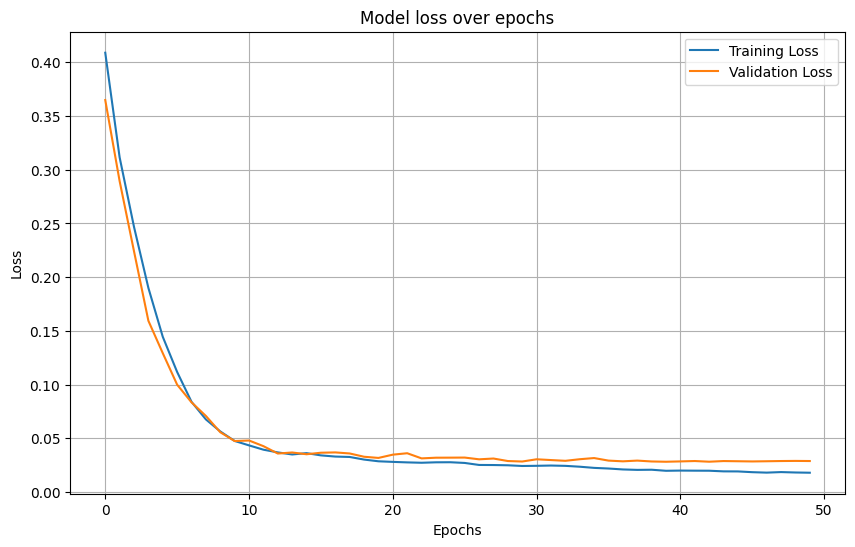

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

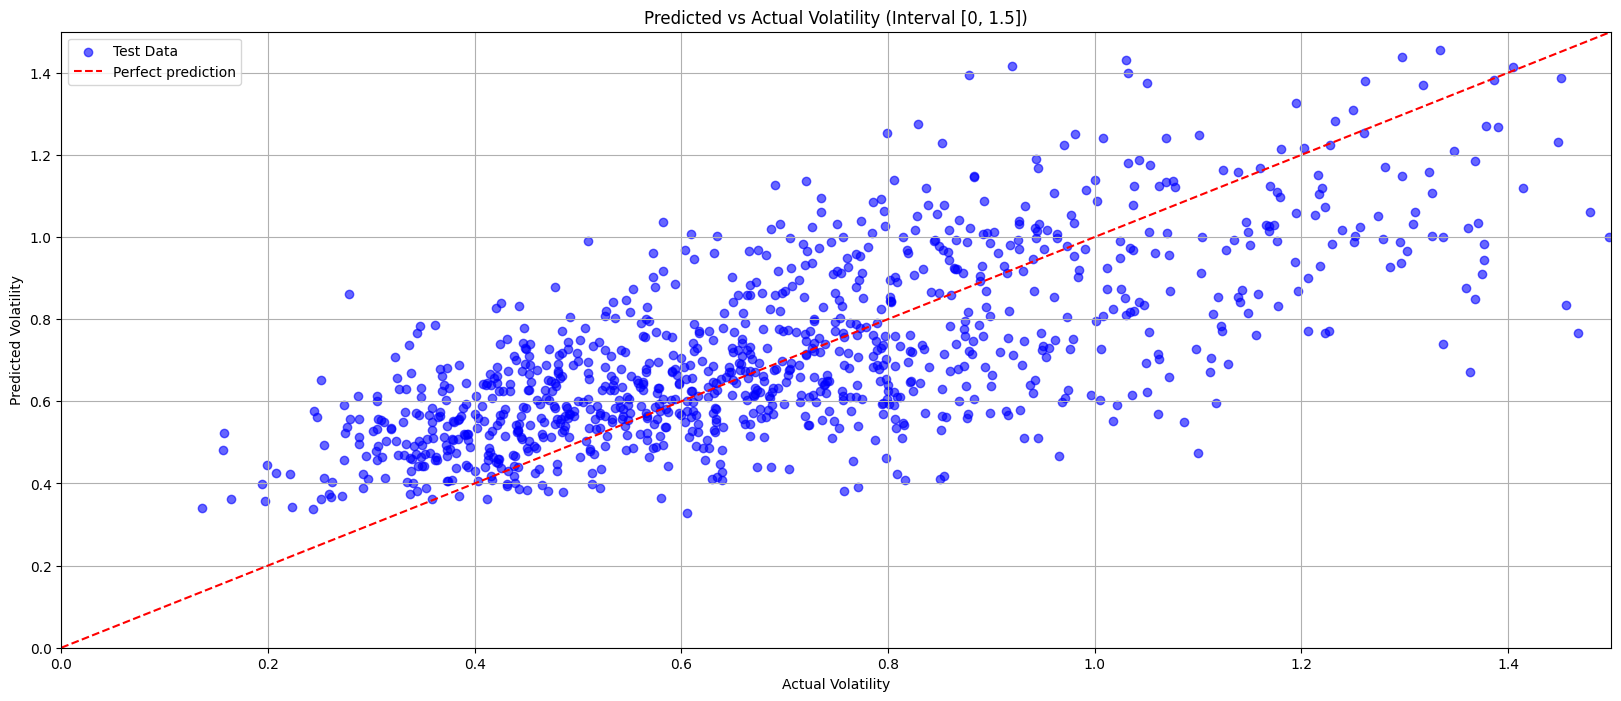

In [14]:
plt.figure(figsize=(20, 8))
plt.scatter(y_test, y_pred, alpha=0.6, label='Test Data', color='blue')

max_value = max(1.5, 1.5)
min_value = max(0, 0)
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Perfect prediction')

plt.xlim(0, 1.5)
plt.ylim(0, 1.5)

plt.title("Predicted vs Actual Volatility (Interval [0, 1.5])")
plt.xlabel("Actual Volatility")
plt.ylabel("Predicted Volatility")
plt.legend()
plt.grid()

plt.show()


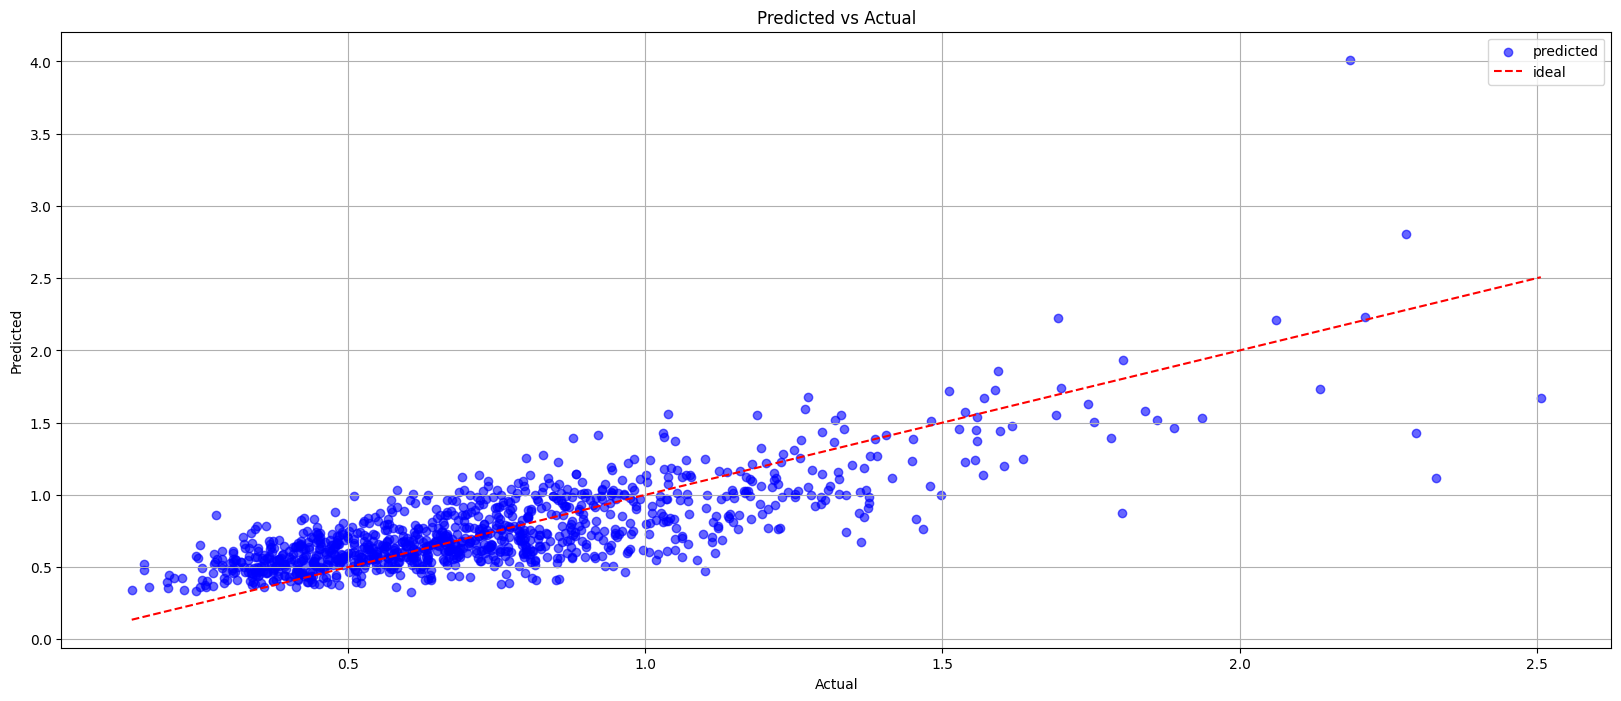

In [15]:
plt.figure(figsize=(20, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


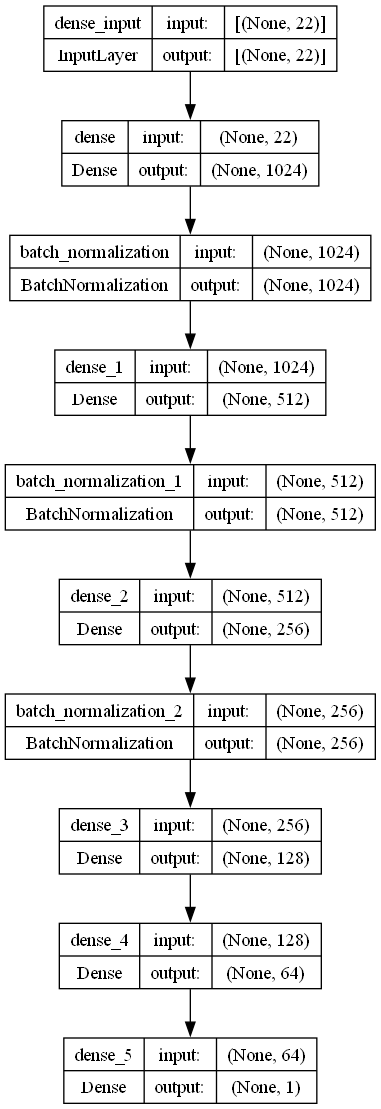

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
